In [1]:
import pandas as pd

In [28]:
month_data = pd.read_csv('../data/etf_mo.csv', encoding='utf-8')
day_data = pd.read_csv('../data/etf_day.csv', encoding='utf-8')

month_data['ret'] = month_data['close'].pct_change()
day_data['ret'] = day_data['close'].pct_change()
month_data.fillna(0, inplace=True)
day_data.fillna(0, inplace=True)
month_data['label'] = month_data['ret'].shift(-1)
month_data.dropna(inplace=True)

In [32]:
train = month_data.iloc[:int(len(month_data) * 0.8)]
test = month_data.iloc[int(len(month_data) * 0.8):]

In [35]:
train_x = train[['open', 'high', 'low', 'close', 'volume']]
train_y = train['label']
test_x = test[['open', 'high', 'low', 'close', 'volume']]
test_y = test['label']

from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

model = XGBRegressor()

model.fit(train_x, train_y)
pred = model.predict(test_x)
print(f"MSE: {mean_squared_error(test_y, pred)}")

0.004677777904256314


In [110]:
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

min_max(pred)

array([0.04727814, 0.00991136, 0.04137488, 0.02435333, 0.04137488,
       0.36351052, 0.        , 0.08327325, 0.04054087, 0.05411404,
       0.18586496, 0.3869754 , 0.8912245 , 0.86146384, 0.9525248 ,
       0.8784853 , 0.8714886 , 0.38654137, 0.40719208, 0.8784853 ,
       0.8776514 , 0.8480969 , 0.8641362 , 1.        , 0.9062454 ,
       0.8391173 , 0.8391173 , 0.8391173 , 0.9286456 , 0.8912245 ,
       0.83228266, 0.8947702 , 0.3869754 , 0.48084894, 0.05784308,
       0.04966146, 0.01218389], dtype=float32)

In [81]:
## get benchmark
import numpy as np

day_data['ym'] = day_data['Date'].apply(lambda x: x[:7])
month_data['ym'] = month_data['Date'].apply(lambda x: x[:7])
profit = np.zeros((len(day_data), len(month_data)))
unique_ym = month_data['ym'].unique()

cum_len = 0
for idx, ele in enumerate(unique_ym):
    subdf = day_data[day_data['ym'] == ele]
    cum_ret = [
        (day_data['close'].iloc[i] - day_data['open'].iloc[cum_len]) / day_data['open'].iloc[cum_len]
        for i in range(cum_len, len(day_data))
    ]
    profit[cum_len:, idx] = cum_ret
    cum_len += len(subdf)

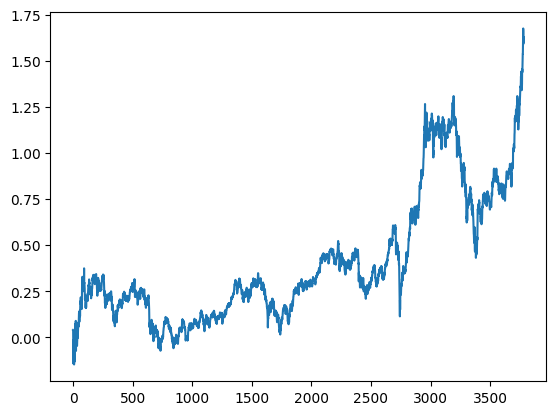

In [103]:
# true_profit = np.sum(profit, axis=1)
mask = np.where(profit != 0, 1, 0)
entries = np.sum(mask, axis=1)
true_profit = np.sum(profit, axis=1) / entries

plt.plot(true_profit, label='true')